In [1]:
import pandas as pd
import numpy as np

# Different possible regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

# Other process packages
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
# import statsmodels

# Model scoring and assessment packages
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import root_mean_squared_error

# Model optimization packages
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Visualization packages
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

In [26]:
def plot_permutation_importance(clf, X, y, scoring, random_state, ax):
    result = permutation_importance(clf,
        X,
        y,
        scoring=scoring,
        n_repeats=10,
        random_state=random_state,
        n_jobs=-1)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    ax.set_xlabel(scoring)

    fig.tight_layout()
    plt.show()

    return ax

def display_feature_importance(clf, X_train, X_test, y_train, y_test):
    results = pd.Series(
        clf.feature_importances_,
        index=clf.feature_names_in_,
        ).sort_values(ascending=False)
    print("Feature Importance Ranking:\n", results.index)
    results.plot.bar(figsize=(15, 5))
    r = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{clf.feature_names_in_[i]:<8}"
                f"{r.importances_mean[i]:.3f}"
                f" +/- {r.importances_std[i]:.3f}")
    mdi_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))
    mdi_importances.sort_values().plot.barh(ax=ax1)
    ax1.set_xlabel("Gini Importance")
    plot_permutation_importance(clf, X_train, y_train, "neg_root_mean_squared_error", 42, ax2)
    ax2.set_xlabel("Decrease in neg_root_mean_squared_error")
    # fig.subtitle(
    #     "Impurity-based Feature Importance vs Permutation Importances /n on multicolinear features (train set)")
    _ = fig.tight_layout()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    plot_permutation_importance(clf, X_test, y_test, "neg_root_mean_squared_error", 42, ax)
    ax.set_title("Permutation Importances (test set)")
    ax.set_xlabel("Decrease in neg_root_mean_squared_error")
    _ = ax.figure.tight_layout()
    plt.show()

In [3]:
df = pd.read_csv('final_merge.csv')
print(f'Dataframe shape: {df.shape}')
print(f'dataframe columns: {df.columns}')

# Drop columns with percentages
df = df[df.columns.drop(list(df.filter(regex='Percent')))]
df.describe()

Dataframe shape: (1730, 55)
dataframe columns: Index(['Unnamed: 0', 'disasterNumber', 'declarationTitle', 'state', 'Date_x',
       'fipsStateCode', 'fipsCountyCode', 'year', 'county', 'validReg_own',
       'DamageBetween1and1000', 'DamageBetween10001and2000',
       'DamageBetween20001and3000', 'DamageGreaterThan3000', 'validReg_rent',
       'ModerateDamage_rent', 'MajorDamage_rent', 'SubstDamage_rent',
       'fipsCode', 'LATITUDE_county', 'LONGITUDE_county',
       'Geographic Area Name',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units',
       'Percent!!HOUSING OCCUPANCY!!Total housing units',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
       'Percent!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
       'Percent!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing 

,Unnamed: 0,disasterNumber,fipsStateCode,fipsCountyCode,year,validReg_own,DamageBetween1and1000,DamageBetween10001and2000,DamageBetween20001and3000,DamageGreaterThan3000,...,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier,Date_y,Max Wind,Max Pressure,Landfall_Lat,Landfall_Lon,dist_from_landfall
count,1730.0000,1730.000000,1730.000000,1730.000000,1730.000000,1713.000000,1713.000000,1713.000000,1713.000000,1713.000000,...,1730.000000,1730.000000,1730.000000,1730.000000,1.730000e+03,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000
mean,864.5000,3094.516763,31.530636,108.391908,2012.023699,6090.835960,1841.802685,155.615295,53.805604,66.267951,...,7281.291908,4995.699422,2400.882081,2139.339306,2.012114e+07,97.234104,953.211561,28.673815,-82.800289,236.829505
std,499.5523,1458.354903,20.591525,119.229293,7.755594,17289.765569,5212.056569,784.883876,372.534664,511.160118,...,16648.966254,12298.887890,6137.119990,5229.259202,7.756742e+04,19.661540,17.364006,4.368017,7.763506,250.074421
min,0.0000,1479.000000,1.000000,1.000000,2003.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,39.000000,41.000000,-71.000000,-61.000000,2.003072e+07,65.000000,919.000000,18.000000,-97.200000,4.543943
25%,432.2500,1554.000000,12.000000,43.000000,2004.000000,324.000000,138.000000,2.000000,0.000000,0.000000,...,1129.750000,709.250000,357.250000,371.000000,2.004092e+07,80.000000,939.000000,27.200000,-87.900000,81.909737
50%,864.5000,4019.000000,28.000000,83.000000,2011.000000,1359.000000,464.000000,15.000000,2.000000,2.000000,...,2273.000000,1424.500000,768.000000,790.500000,2.011083e+07,95.000000,952.000000,29.300000,-82.200000,152.902961
75%,1296.7500,4400.000000,48.000000,123.000000,2018.000000,4862.000000,1434.000000,73.000000,13.000000,13.000000,...,5992.000000,3657.750000,1880.500000,1896.250000,2.018101e+07,110.000000,965.000000,30.200000,-79.500000,270.123505
max,1729.0000,4834.000000,72.000000,840.000000,2024.000000,331674.000000,99520.000000,23576.000000,11003.000000,11077.000000,...,240198.000000,145008.000000,99878.000000,63843.000000,2.024101e+07,140.000000,986.000000,34.900000,-65.900000,1312.120049


In [4]:
df.head()

,Unnamed: 0,disasterNumber,declarationTitle,state,Date_x,fipsStateCode,fipsCountyCode,year,county,validReg_own,...,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier,Name,Date_y,Latitude,Longitude,Max Wind,Max Pressure,Landfall_Lat,Landfall_Lon,dist_from_landfall
0,0,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,15,2024,Austin (County),582.0,...,1147,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,87.175749
1,1,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,37,2024,Bowie (County),495.0,...,1384,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,349.863220
2,2,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,39,2024,Brazoria (County),44176.0,...,1766,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,63.975663
3,3,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,71,2024,Chambers (County),3431.0,...,333,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,111.469171
4,4,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,157,2024,Fort Bend (County),79137.0,...,2457,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,72.859249


In [5]:
df['declarationTitle'].rename('Name')
df['Name'] = df['Name'].str.replace('HURRICANE ', '')
df.columns

Index(['Unnamed: 0', 'disasterNumber', 'declarationTitle', 'state', 'Date_x',
       'fipsStateCode', 'fipsCountyCode', 'year', 'county', 'validReg_own',
       'DamageBetween1and1000', 'DamageBetween10001and2000',
       'DamageBetween20001and3000', 'DamageGreaterThan3000', 'validReg_rent',
       'ModerateDamage_rent', 'MajorDamage_rent', 'SubstDamage_rent',
       'fipsCode', 'LATITUDE_county', 'LONGITUDE_county',
       'Geographic Area Name',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 19

In [6]:
df_closest_pass = pd.read_csv('closest_pass.csv')
df_closest_pass.rename(columns={'Max Wind':'Closest_Max_Wind', 
                                'Max Pressure':'Closest_Max_Pressure'}, inplace=True)

df_closest_pass.describe()


,year,Closest_Max_Wind,Closest_Max_Pressure,fipsCode,distance_from_storm
count,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000
mean,2012.023699,70.953757,967.283815,31639.027746,81.440583
std,7.755594,26.084641,19.664091,20614.641817,106.528373
min,2003.000000,20.000000,919.000000,1001.000000,3.563970
25%,2004.000000,50.000000,952.000000,12117.500000,34.895796
50%,2011.000000,70.000000,969.000000,28038.000000,56.364773
75%,2018.000000,85.000000,983.000000,48071.000000,93.427001
max,2024.000000,140.000000,1007.000000,72153.000000,1000.000000


In [7]:
df_closest_pass.head()

,Name,year,Closest_Max_Wind,Closest_Max_Pressure,fipsCode,distance_from_storm,category
0,BERYL,2024,70,978,48015,40.192025,TS
1,BERYL,2024,25,1004,48037,6.349638,TD
2,BERYL,2024,70,978,48039,37.310013,TS
3,BERYL,2024,50,988,48071,79.163470,TS
4,BERYL,2024,70,978,48157,29.248125,TS


In [8]:
df = pd.merge(left=df, right=df_closest_pass, on=['Name', 'year', 'fipsCode'])
df.head()

,Unnamed: 0,disasterNumber,declarationTitle,state,Date_x,fipsStateCode,fipsCountyCode,year,county,validReg_own,...,Longitude,Max Wind,Max Pressure,Landfall_Lat,Landfall_Lon,dist_from_landfall,Closest_Max_Wind,Closest_Max_Pressure,distance_from_storm,category
0,0,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,15,2024,Austin (County),582.0,...,96.0W,80,978,28.6,-96.0,87.175749,70,978,40.192025,TS
1,1,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,37,2024,Bowie (County),495.0,...,96.0W,80,978,28.6,-96.0,349.863220,25,1004,6.349638,TD
2,2,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,39,2024,Brazoria (County),44176.0,...,96.0W,80,978,28.6,-96.0,63.975663,70,978,37.310013,TS
3,3,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,71,2024,Chambers (County),3431.0,...,96.0W,80,978,28.6,-96.0,111.469171,50,988,79.163470,TS
4,4,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,157,2024,Fort Bend (County),79137.0,...,96.0W,80,978,28.6,-96.0,72.859249,70,978,29.248125,TS


In [9]:
# Create dependent variable as sum of "damage" columns (replacing Nan values with 0)
df['Damage'] = df['DamageBetween20001and3000'].fillna(0) + df['DamageGreaterThan3000'].fillna(0) + df['MajorDamage_rent'].fillna(0)
df['lnDamage'] = np.log(df['Damage']
                        + 1)  # Use natural log of 'Damage' + 1 given disproportionate number of small values (including 0)

# # Delete original "damage" columns
# df = df.drop(df.columns[0:3], axis=1)

# # Move dependent variable to first column position
# col = df.pop('lnDamage')
# df.insert(0, 'lnDamage', col)
# col = df.pop('Damage')
# df.insert(0, 'Damage', col)

df = df[
    ['Damage',
    'lnDamage',
    'disasterNumber',
    'Estimate!!HOUSING OCCUPANCY!!Total housing units',
    'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
    'Max Wind',
    'Max Pressure',
    'dist_from_landfall',
    'Closest_Max_Wind',
    'Closest_Max_Pressure',
    'distance_from_storm',
    'category'
    ]
]

print(f'Count NaN values: {df.isna().any()}') # Damage column has Nan values initially


df.describe()

Count NaN values: Damage                                                                        False
lnDamage                                                                      False
disasterNumber                                                                False
Estimate!!HOUSING OCCUPANCY!!Total housing units                              False
Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units      False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later      False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built

,Damage,lnDamage,disasterNumber,Estimate!!HOUSING OCCUPANCY!!Total housing units,Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989,...,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier,Max Wind,Max Pressure,dist_from_landfall,Closest_Max_Wind,Closest_Max_Pressure,distance_from_storm
count,1730.000000,1730.000000,1730.000000,1.730000e+03,1.730000e+03,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000,...,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000
mean,141.176879,2.312448,3094.516763,6.349815e+04,5.324037e+04,432.203468,3161.845087,9175.574566,10463.243353,11651.222543,...,7281.291908,4995.699422,2400.882081,2139.339306,97.234104,953.211561,236.829505,70.953757,967.283815,81.440583
std,885.135579,2.008557,1458.354903,1.326282e+05,1.150109e+05,2166.836281,13429.402668,21645.534228,19864.941661,24310.912772,...,16648.966254,12298.887890,6137.119990,5229.259202,19.661540,17.364006,250.074421,26.084641,19.664091,106.528373
min,0.000000,0.000000,1479.000000,4.670000e+02,2.740000e+02,0.000000,0.000000,9.000000,29.000000,46.000000,...,39.000000,41.000000,-71.000000,-61.000000,65.000000,919.000000,4.543943,20.000000,919.000000,3.563970
25%,1.000000,0.693147,1554.000000,9.340750e+03,7.532250e+03,0.000000,0.000000,823.750000,1506.500000,1613.250000,...,1129.750000,709.250000,357.250000,371.000000,80.000000,939.000000,81.909737,50.000000,952.000000,34.895796
50%,6.000000,1.945910,4019.000000,1.890450e+04,1.552500e+04,0.000000,36.500000,2154.500000,3241.000000,3303.000000,...,2273.000000,1424.500000,768.000000,790.500000,95.000000,952.000000,152.902961,70.000000,969.000000,56.364773
75%,35.000000,3.583519,4400.000000,5.814600e+04,4.967700e+04,0.000000,793.750000,7793.250000,10269.750000,9818.750000,...,5992.000000,3657.750000,1880.500000,1896.250000,110.000000,965.000000,270.123505,85.000000,983.000000,93.427001
max,21555.000000,9.978409,4834.000000,1.942862e+06,1.789470e+06,48370.000000,343520.000000,341119.000000,222934.000000,297831.000000,...,240198.000000,145008.000000,99878.000000,63843.000000,140.000000,986.000000,1312.120049,140.000000,1007.000000,1000.000000


In [10]:
df = pd.get_dummies(df,
               columns=['category'],
               dtype=int)
df.head()

,Damage,lnDamage,disasterNumber,Estimate!!HOUSING OCCUPANCY!!Total housing units,Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989,...,dist_from_landfall,Closest_Max_Wind,Closest_Max_Pressure,distance_from_storm,category_1,category_2,category_3,category_4,category_TD,category_TS
0,6.0,1.945910,4798,14490.0,12610.0,607,2124,3029,2123,1930,...,87.175749,70,978,40.192025,0,0,0,0,0,1
1,1.0,0.693147,4798,39773.0,35163.0,450,5102,4043,7717,6694,...,349.863220,25,1004,6.349638,0,0,0,0,1,0
2,113.0,4.736198,4798,151738.0,136014.0,5397,33277,30493,20487,19722,...,63.975663,70,978,37.310013,0,0,0,0,0,1
3,4.0,1.609438,4798,19330.0,17802.0,1588,4409,4838,2592,1614,...,111.469171,50,988,79.163470,0,0,0,0,0,1
4,25.0,3.258097,4798,314720.0,302947.0,16692,104372,74473,41857,37753,...,72.859249,70,978,29.248125,0,0,0,0,0,1


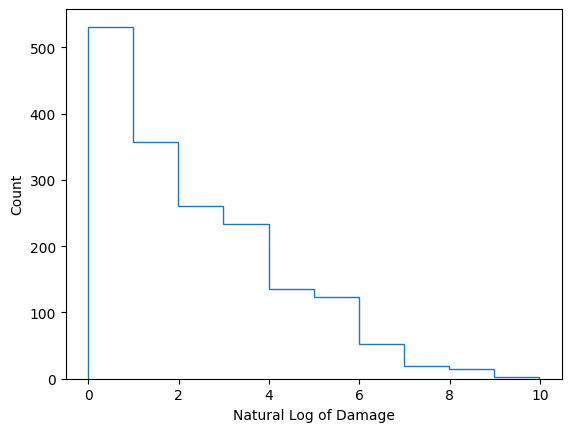

In [11]:
# Plot the dependent variable, 'Damage'

counts, bins = np.histogram(df['lnDamage'])
plt.stairs(counts, bins)
plt.xlabel('Natural Log of Damage')
plt.ylabel('Count')
plt.show()

In [12]:
df['wind_speed_div_distance'] = df['Max Wind'] / df['dist_from_landfall']

In [13]:
# Scale the dataframe
'''
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data,
                         columns=df.columns)
'''

scaler = Normalizer()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data,
                         columns=df.columns)

In [14]:
# Split the dataset in training and test subsets
X = df.drop(['Damage','lnDamage'], axis=1)
y = (df['lnDamage']) # Use natural log of 'Damage' + 1 given disproportionate number of small values (including 0)


In [15]:
lr_clf = LinearRegression()
br_clf = BayesianRidge()
rf_clf = RandomForestRegressor(random_state=0)
SVR_clf = SVR(kernel='rbf')
gbr_clf = GradientBoostingRegressor(random_state=0)

clf_list = [lr_clf, br_clf, rf_clf, SVR_clf, gbr_clf]
groups = X['disasterNumber']
X_ = X.drop(['disasterNumber'], axis=1)
groupkfold = GroupKFold(n_splits=10)
for clf in clf_list:
    # cross_val_results = cross_val_score(clf, X_, y, groups=groups, cv=groupkfold, scoring='r2')
    cross_val_results = cross_val_score(clf, X_, y, cv=5, scoring='r2')

    print(f'{clf} Mean: {cross_val_results.mean()}')
    print(f'{clf} Standard Deviation: {cross_val_results.std()}')


LinearRegression() Mean: 0.15649573049611834
LinearRegression() Standard Deviation: 0.13285431307385073
BayesianRidge() Mean: 0.16755154266296776
BayesianRidge() Standard Deviation: 0.13183427323467597
RandomForestRegressor(random_state=0) Mean: 0.30578979613749696
RandomForestRegressor(random_state=0) Standard Deviation: 0.08918135676989794
SVR() Mean: 0.04221407073079404
SVR() Standard Deviation: 0.09385460298677267
GradientBoostingRegressor(random_state=0) Mean: 0.28402726128373823
GradientBoostingRegressor(random_state=0) Standard Deviation: 0.10074484568152303


In [16]:
#pipe_linreg = Pipeline([('scaler', StandardScaler()), ('algorithm', LinearRegression())])
X_train, X_test, y_train, y_test = train_test_split(X_,y,test_size=0.2, random_state=50)
# train_indices, test_indices = next(GroupShuffleSplit(
#     n_splits=1,
#     test_size=0.2,
#     random_state=50
# ).split(X, y,groups=X['disasterNumber']))

# X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
# y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
# groups = X_train['disasterNumber']
# X_train = X_train.drop(['disasterNumber'], axis=1)
# X_test = X_test.drop(['disasterNumber'], axis=1)

lr_clf = LinearRegression().fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)
lr_score = lr_clf.score(X_test, y_test)

br_clf = BayesianRidge().fit(X_train, y_train)
br_preds = br_clf.predict(X_test)
br_score = br_clf.score(X_test, y_test)

rf_clf = RandomForestRegressor(random_state=0).fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)
rf_score = rf_clf.score(X_test, y_test)

SVR_clf = SVR(kernel='rbf').fit(X_train, y_train)
SVR_preds = SVR_clf.predict(X_test)
SVR_score = SVR_clf.score(X_test, y_test)

gbr_clf = GradientBoostingRegressor(random_state=0).fit(X_train, y_train)
gbr_preds = gbr_clf.predict(X_test)
gbr_score = gbr_clf.score(X_test, y_test)

print(f'Linear Regression Score: {lr_score}')
print(f'Bayesian Ridge Score: {br_score}')
print(f'Random Forest Score: {rf_score}')
print(f'SVR Score: {SVR_score}')
print(f'Gradient Boosting Regressor Score: {gbr_score}')


Linear Regression Score: 0.270016341635021
Bayesian Ridge Score: 0.2551374427103775
Random Forest Score: 0.5967609849903486
SVR Score: 0.09818950739690302
Gradient Boosting Regressor Score: 0.5471523929446398


In [17]:
# Model metrics for random forest model
print(f'Score: {rf_clf.score(X_test, y_test)}')
print(f'R2 Score: {r2_score(y_test, rf_preds)}')
print(f'MSE: {mean_squared_error(y_test, rf_preds)}')
print(f'MAE: {mean_absolute_error(y_test, rf_preds)}')
print(f'Median Absolute Error: {median_absolute_error(y_test, rf_preds)}')
print(f'RMSE: {root_mean_squared_error(y_test, rf_preds)}')
print(f'Cross Validation Score: {cross_val_score(rf_clf, X_train, y_train, cv=5).mean()}')

Score: 0.5967609849903486
R2 Score: 0.5967609849903486
MSE: 1.4638356566434705
MAE: 0.9257070399691937
Median Absolute Error: 0.7309007735442964
RMSE: 1.2098907622771036
Cross Validation Score: 0.596177756480186


In [18]:
# param_dist = {
#     "learning_rate": stats.uniform(0, 1),
#     "subsample": stats.uniform(0, 1),
#     "max_depth": stats.randint(1, 20),
#     "n_estimators": stats.randint(50, 150),
#     "max_features": stats.uniform(0, 1),
#     "loss": ["ls", "lad", "huber", "quantile"],
# }

# clf = GradientBoostingRegressor(random_state=0)

# n_iter_search = 50
# random_search_gbr = RandomizedSearchCV(
#     clf, 
#     param_distributions=param_dist, 
#     n_iter=n_iter_search, 
#     random_state=0,
#     cv = groupkfold,
#     scoring='r2',
#     return_train_score=True,
# )

# random_search_gbr.fit(X_train, y_train, groups=groups)

# best_model_gbr = random_search_gbr.best_estimator_
# best_model_gbr.fit(X_train, y_train)
# print(random_search_gbr.best_params_)


In [19]:
# gbr_preds = best_model_gbr.predict(X_test)
# gbr_score = best_model_gbr.score(X_test, y_test)
# print(f'Gradient Boosting Regressor Score: {gbr_score}')


In [20]:
param_dist = {
    "max_depth": stats.randint(1, 20),
    "n_estimators": stats.randint(50, 150),
    "max_features": stats.uniform(0, 1),
    "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    # "min_samples_split": stats.uniform(0, 1),
    # "min_samples_leaf": stats.uniform(0, 1),
}

clf = RandomForestRegressor(random_state=0)

# n_iter_search = 50
# random_search_rfr = RandomizedSearchCV(
#     clf, param_distributions=param_dist, n_iter=n_iter_search, random_state=0
# )

n_iter_search = 20
random_search_rfr = RandomizedSearchCV(
    clf, 
    param_distributions=param_dist, 
    n_iter=n_iter_search, 
    random_state=0,
    cv = 5,
    scoring='r2',
    return_train_score=True,
)

# random_search_rfr.fit(X_train, y_train, groups=groups)
random_search_rfr.fit(X_train, y_train,)


print(random_search_rfr.best_params_)
best_model_rfr = random_search_rfr.best_estimator_
best_model_rfr.fit(X_train, y_train)

{'criterion': 'squared_error', 'max_depth': 16, 'max_features': 0.7151893663724195, 'n_estimators': 117}


RandomForestRegressor(max_depth=16, max_features=0.7151893663724195,
                      n_estimators=117, random_state=0)

In [21]:
rfr_preds = best_model_rfr.predict(X_test)
rfr_score = best_model_rfr.score(X_test, y_test)
print(f'Random Forest Regressor Score: {rfr_score}')


Random Forest Regressor Score: 0.612863383541306


In [33]:
states = list(range(1,11))
score_list = []
for i in states:
    X_train, X_test, y_train, y_test = train_test_split(X_,y,test_size=0.2, random_state=i)
    best_model_rfr.fit(X_train, y_train)
    score_list.append(best_model_rfr.score(X_test, y_test))
print(score_list)
print(np.mean(score_list))
print(np.std(score_list))

[0.6024048434291561, 0.5753337700039874, 0.6317433731892657, 0.6073614649699695, 0.5754416969697465, 0.652852673241755, 0.616719649310524, 0.5953590616423289, 0.5695784865738455, 0.6010125193781658]
0.6027807538708745
0.024945554983261342


C:\Users\josep\AppData\Local\Temp\ipykernel_11544\1072000882.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


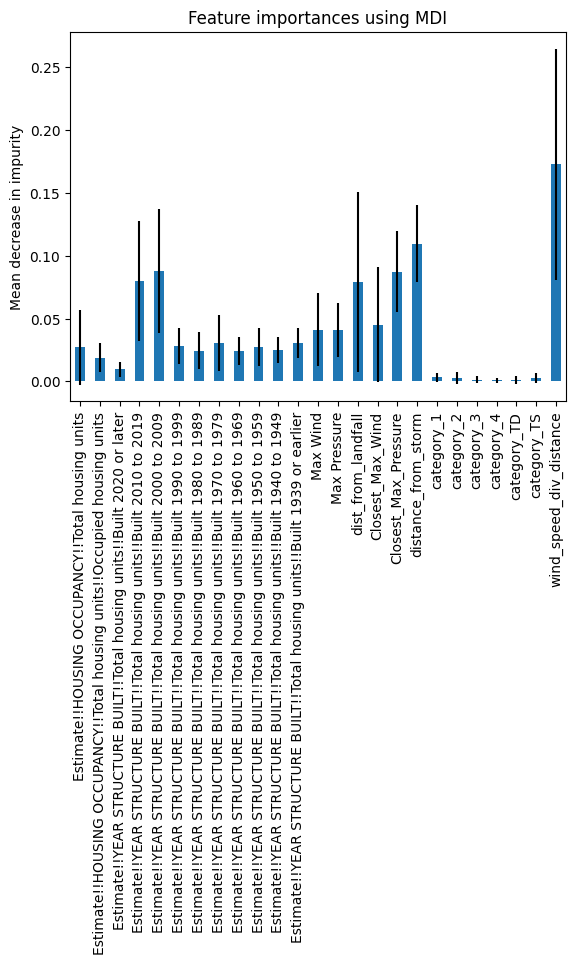

In [23]:
importances = best_model_rfr.feature_importances_
feature_names = [i for i in X_.columns]
std = np.std([tree.feature_importances_ for tree in best_model_rfr.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

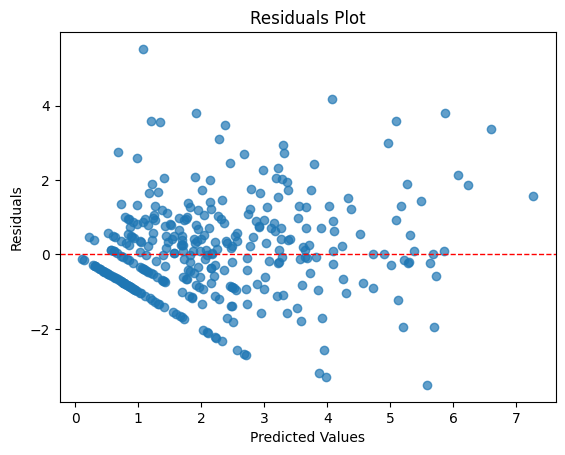

In [24]:
y_pred = best_model_rfr.predict(X_test)
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

Feature Importance Ranking:
 Index(['wind_speed_div_distance', 'distance_from_storm',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
       'Closest_Max_Pressure',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
       'dist_from_landfall', 'Closest_Max_Wind', 'Max Wind', 'Max Pressure',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969',
      

C:\Users\josep\AppData\Local\Temp\ipykernel_11544\3779533742.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


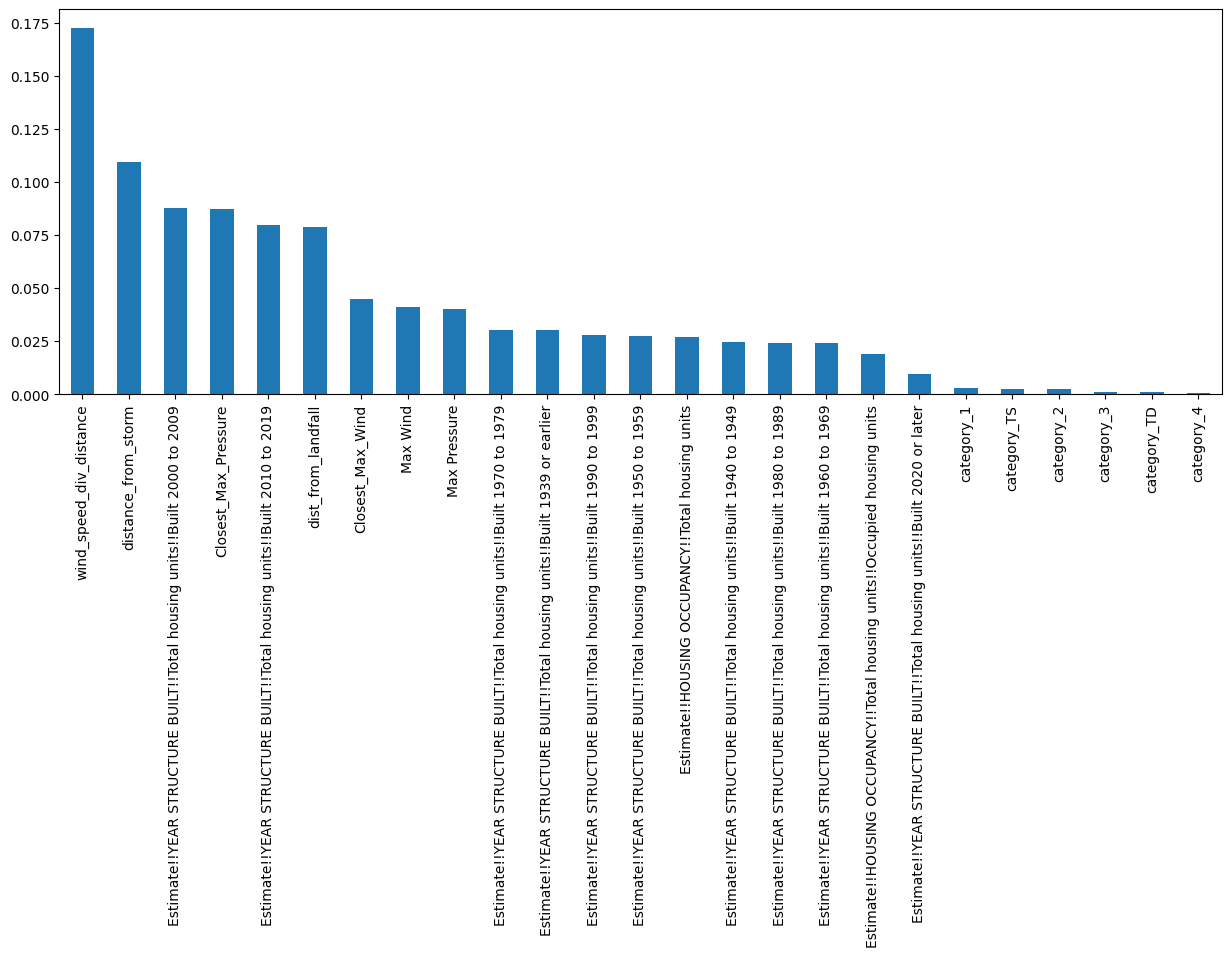

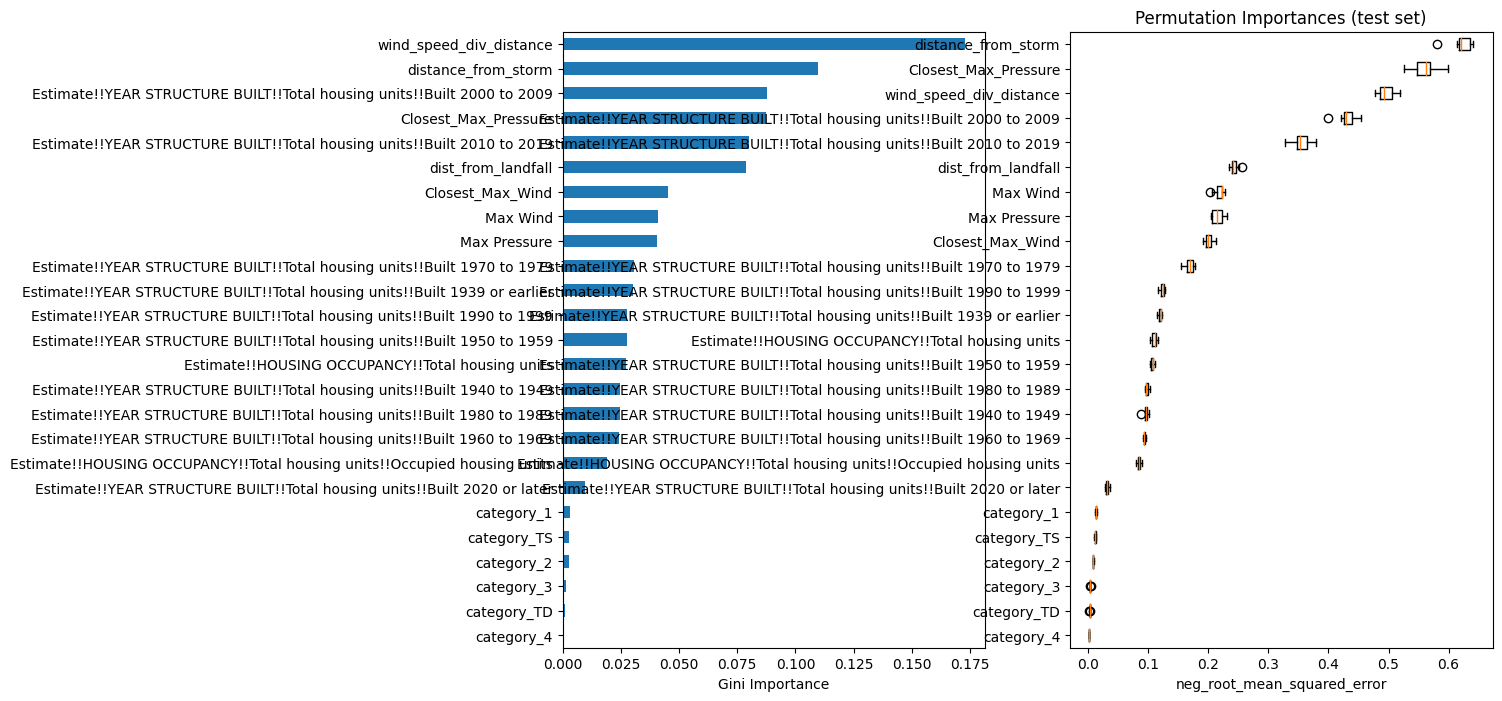

C:\Users\josep\AppData\Local\Temp\ipykernel_11544\3779533742.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


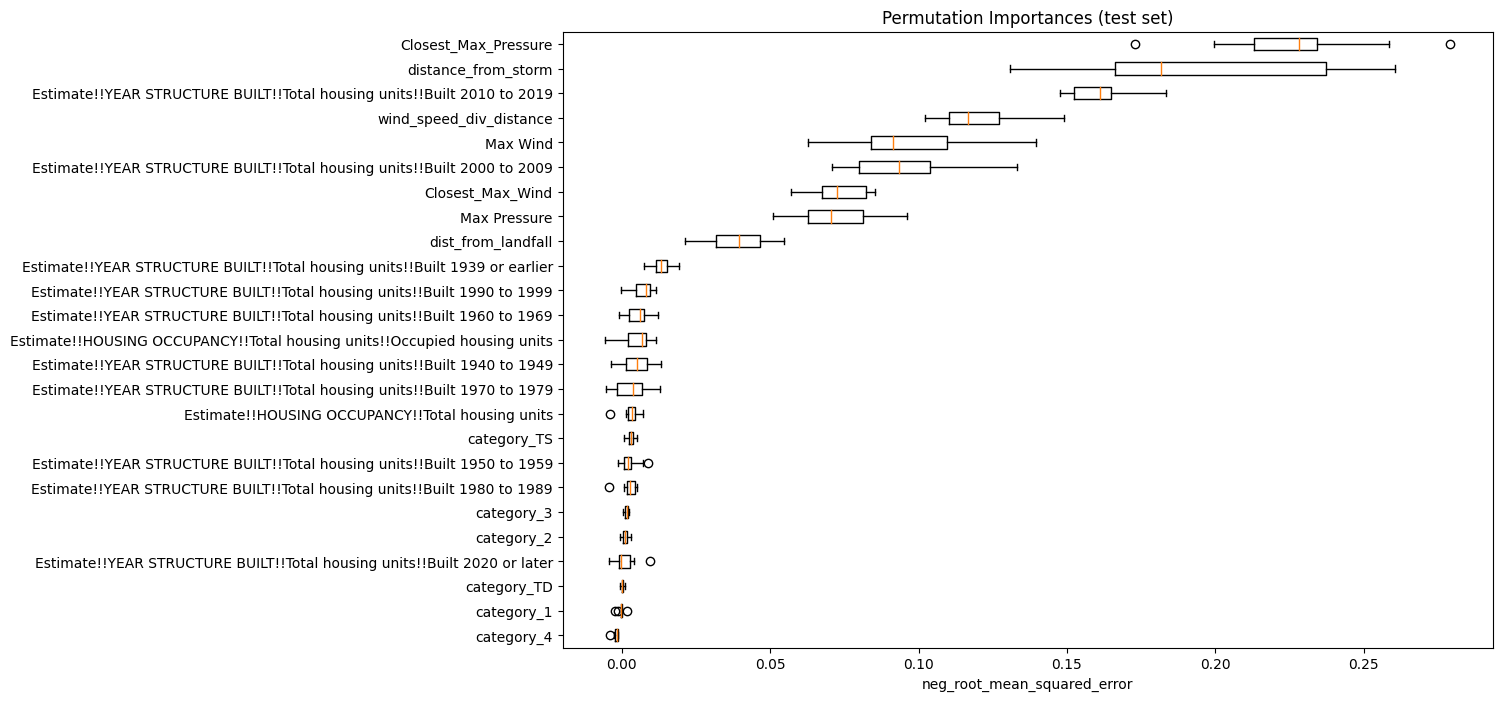

In [27]:
display_feature_importance(best_model_rfr,
                           X_train,
                           X_test,
                           y_train,
                           y_test)

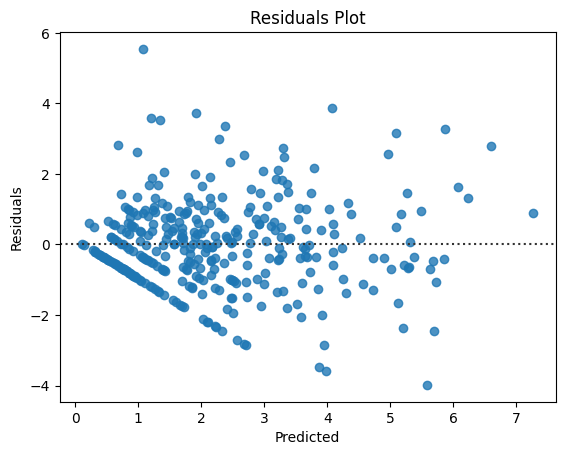

In [ ]:
residuals_df = pd.DataFrame({'Predicted': y_pred, 'Residuals': residuals})

# Residuals plot
sns.residplot(x='Predicted', y='Residuals', data=residuals_df,
#  lowess=True, 
 line_kws={'color': 'red'})
plt.title("Residuals Plot")
plt.show()

In [38]:
states = list(range(1,11))
score_list = []
ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for j in ratios:
    states = list(range(1,11))
    score_list = []
    for i in states:
    # train_indices, test_indices = next(GroupShuffleSplit(
    # n_splits=1,
    # test_size=0.2,
    # random_state=i
    # ).split(X, y,groups=X['disasterNumber']))

    # X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    # y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    # groups = X_train['disasterNumber']
    # X_train = X_train.drop(['disasterNumber'], axis=1)
    # X_test = X_test.drop(['disasterNumber'], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_, y, train_size=j, random_state=i)

        best_model_rfr.fit(X_train, y_train)
        score_list.append(best_model_rfr.score(X_test, y_test))
    print(j)
    print(score_list)
    print(np.mean(score_list))
    print(np.std(score_list))

states = list(range(1,11))
score_list = []
for i in states:
    X_train, X_test, y_train, y_test = train_test_split(X_,y,test_size=0.2, random_state=i)
    best_model_rfr.fit(X_train, y_train)
    score_list.append(best_model_rfr.score(X_test, y_test))
print(score_list)
print(np.mean(score_list))
print(np.std(score_list))

0.1
[0.418804964035825, 0.39612506991071483, 0.41310912426568047, 0.44723308370058634, 0.37083303579013804, 0.4625383835916401, 0.4559405889196123, 0.41972102260300603, 0.4373305386802403, 0.3834093602573987]
0.42050451717548426
0.02918210193654565
0.2
[0.4883983397148536, 0.472406736208023, 0.5048281514043247, 0.5154795714434289, 0.4755188128707256, 0.5048377196216903, 0.5074517105905416, 0.4674806738048267, 0.47667694552938167, 0.41631595849541514]
0.4829394619683211
0.027442750628367568
0.3
[0.5061318092479759, 0.5206498550818341, 0.5327607985412139, 0.5422509909549733, 0.4955353768228614, 0.5391552946171034, 0.5270232427345289, 0.515760520668833, 0.48509959849676443, 0.5070057089786051]
0.5171373196144693
0.01785602436480003
0.4
[0.5790662751819812, 0.5590429204298824, 0.5517494113749812, 0.552383390191236, 0.5211287859088274, 0.5584975307885933, 0.5524375548451497, 0.5609143382954359, 0.5061189490357453, 0.531698167020647]
0.5473037323072478
0.020381335500629115
0.5
[0.57954689285

C:\Users\josep\AppData\Local\Temp\ipykernel_11544\1072000882.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


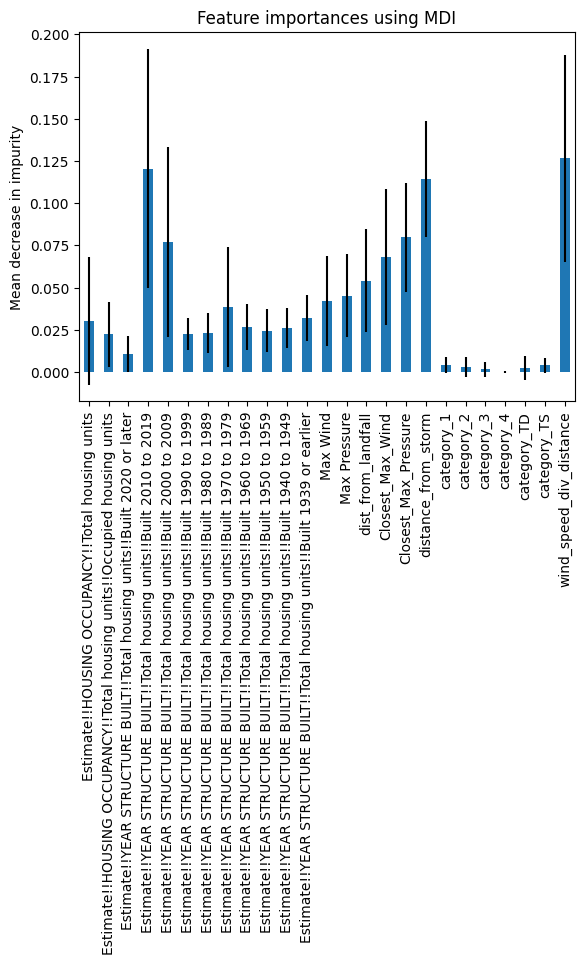

In [29]:
importances = best_model_rfr.feature_importances_
feature_names = [i for i in X_.columns]
std = np.std([tree.feature_importances_ for tree in best_model_rfr.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

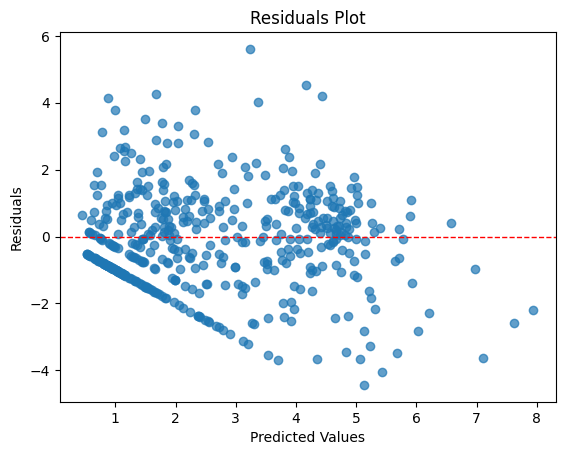

In [ ]:
y_pred = best_model_rfr.predict(X_test)
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

In [39]:
X_.columns

Index(['Estimate!!HOUSING OCCUPANCY!!Total housing units',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
       'Max Wind', 'Max Pressure',

In [44]:
_ = X_.drop(labels=['Estimate!!HOUSING OCCUPANCY!!Total housing units',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units'],
       axis=1,
       )
states = list(range(1,11))
score_list = []
for i in states:
    X_train, X_test, y_train, y_test = train_test_split(_,y,test_size=0.2, random_state=i)
    best_model_rfr.fit(X_train, y_train)
    score_list.append(best_model_rfr.score(X_test, y_test))
print(score_list)
print(np.mean(score_list))
print(np.std(score_list))

_ = X_.drop(labels=[
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
    ],
    axis=1,
    )
states = list(range(1,11))
score_list = []
for i in states:
    X_train, X_test, y_train, y_test = train_test_split(_,y,test_size=0.2, random_state=i)
    best_model_rfr.fit(X_train, y_train)
    score_list.append(best_model_rfr.score(X_test, y_test))
print(score_list)
print(np.mean(score_list))
print(np.std(score_list))

_ = X_.drop(labels=[
        'Max Wind',
        'Max Pressure',
        'dist_from_landfall',
    ],
    axis=1,
    )
states = list(range(1,11))
score_list = []
for i in states:
    X_train, X_test, y_train, y_test = train_test_split(_,y,test_size=0.2, random_state=i)
    best_model_rfr.fit(X_train, y_train)
    score_list.append(best_model_rfr.score(X_test, y_test))
print(score_list)
print(np.mean(score_list))
print(np.std(score_list))

_ = X_.drop(labels=[
        'category_1',
        'category_2',
        'category_3',
        'category_4',
        'category_TD',
        'category_TS',
    ],
    axis=1,
    )
states = list(range(1,11))
score_list = []
for i in states:
    X_train, X_test, y_train, y_test = train_test_split(_,y,test_size=0.2, random_state=i)
    best_model_rfr.fit(X_train, y_train)
    score_list.append(best_model_rfr.score(X_test, y_test))
print(score_list)
print(np.mean(score_list))
print(np.std(score_list))

[0.61100619197145, 0.5722119354373135, 0.6353178459915544, 0.6054467418470402, 0.5801025658270305, 0.6424632969387345, 0.6212234450138969, 0.6016039309520564, 0.5671020009219523, 0.596449226841992]
0.6032927181743022
0.02410154170591713
[0.6313025225744677, 0.5530212491554498, 0.6261967591904749, 0.5898400533284087, 0.5678251307166051, 0.622867151763163, 0.6159921864098721, 0.5997160085589132, 0.5678888027018894, 0.5710959652618199]
0.5945745829661064
0.027133974820342775
[0.5608794868355063, 0.5539962178536504, 0.6001821074489885, 0.5875710165355366, 0.5409781827482792, 0.6183837966749083, 0.5715154950449299, 0.5728995002704489, 0.5207779145233208, 0.5354166342580882]
0.5662600352193657
0.02869131582718906
[0.5980405242353806, 0.5722456072862481, 0.6342478747740462, 0.6096327623066069, 0.578661535368034, 0.6343185975091709, 0.6174011982911841, 0.5915564350918794, 0.5551974047596069, 0.5954820246783412]
0.5986783964300498
0.02461150721891913


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6a6374cd-5e77-49b2-b1d3-d73b9b2f23ac' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>